In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import pickle

csv_path = './data/ad_connectivity_matrix.csv'
W_df = pd.read_csv(csv_path, index_col=0, header=0)

W = W_df.values.astype(np.float32)

# Min-max normalization so entire matrix is in [0, 1]
W_min = W.min()
W_max = W.max()
W = (W - W_min) / (W_max - W_min + 1e-8)

class DrosophilaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, W_matrix):
        super(DrosophilaRNN, self).__init__()
        # Map input -> hidden
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=True)
        # Map hidden -> output
        self.hidden_to_output = nn.Linear(hidden_size, output_size, bias=True)
        # for trainable W use nn.Parameter
        self.register_buffer("W_matrix", nn.Parameter(
            torch.tensor(W_matrix*1e-5, dtype=torch.float32)
        ))
        # self.W_matrix = torch.tensor(W_matrix, dtype=torch.float32)
        self.hidden_size = hidden_size

    def forward(self, x):
        batch_size, time_steps, _ = x.shape
        # r(0) = 0
        r_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(time_steps):
            E_t = x[:, t, :]                    # (batch_size, input_size)
            E_t_hidden = self.input_to_hidden(E_t)
            r_prev = r_t # for residual
            
            # 
            r_t = r_t @ self.W_matrix          
            r_t = r_t + E_t_hidden + r_prev    # residual/skip
            r_t = torch.relu(r_t)

        out = self.hidden_to_output(r_t)       # (batch_size, output_size)
        return out

def load_mnist_data(batch_size=64):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization
    ])


    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    batch_size = 64
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(W, device, num_epochs=10, batch_size=64, tag="drosophila"):

    train_loader, test_loader = load_mnist_data(batch_size=batch_size)

    input_size = 28
    hidden_size = W.shape[0]
    output_size = 10
    
    model = DrosophilaRNN(input_size, hidden_size, output_size, W).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Training [{tag}] Epoch {epoch+1}/{num_epochs}")
            for images, labels in tepoch:
                # images shape: (batch_size, 1, 28, 28)
                images = images.squeeze(1).to(device)  # -> (batch_size, 28, 28)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                tepoch.set_postfix(
                    loss=loss.item(), accuracy=100. * correct / total
                )

        epoch_acc = correct / total
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total:.4f}, "
              f"Accuracy: {epoch_acc:.4f}")

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.squeeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    test_accuracy = test_correct / test_total
    print(f"[{tag}] Test Accuracy: {test_accuracy:.4f}")

    results = {
        'train_accuracies': train_accuracies,
        'test_accuracy': test_accuracy,
        'tag': tag
    }

    with open(f'results_{tag}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

size = 2952  

train_model(W, device, num_epochs=5, batch_size=64, tag="drosophila_origin")

# W_random = torch.randn(size, size)
# train_model(W_random, device, num_epochs=3, batch_size=64, tag="random_origin")

Using device: cuda


Training [drosophila_origin] Epoch 1/5: 100%|██████████| 938/938 [01:06<00:00, 14.04batch/s, accuracy=50.7, loss=1.11] 


Epoch 1/5, Loss: 1.5247, Accuracy: 0.5068


Training [drosophila_origin] Epoch 2/5: 100%|██████████| 938/938 [01:21<00:00, 11.55batch/s, accuracy=71.2, loss=0.925]


Epoch 2/5, Loss: 0.9766, Accuracy: 0.7116


Training [drosophila_origin] Epoch 3/5: 100%|██████████| 938/938 [01:20<00:00, 11.68batch/s, accuracy=77.4, loss=0.534]


Epoch 3/5, Loss: 0.7925, Accuracy: 0.7738


Training [drosophila_origin] Epoch 4/5: 100%|██████████| 938/938 [01:20<00:00, 11.63batch/s, accuracy=80.6, loss=0.465]


Epoch 4/5, Loss: 0.6866, Accuracy: 0.8063


Training [drosophila_origin] Epoch 5/5: 100%|██████████| 938/938 [01:18<00:00, 11.97batch/s, accuracy=82.6, loss=0.314]


Epoch 5/5, Loss: 0.6182, Accuracy: 0.8262
[drosophila_origin] Test Accuracy: 0.8407


{'train_accuracies': [0.5068166666666667,
  0.7116333333333333,
  0.7738,
  0.8063,
  0.8262166666666667],
 'test_accuracy': 0.8407,
 'tag': 'drosophila_origin'}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from thop import profile  

# Load and preprocess the connectivity matrix
csv_path = './data/ad_connectivity_matrix.csv'
W_df = pd.read_csv(csv_path, index_col=0, header=0)
W = W_df.values.astype(np.float32)
W_min = W.min()
W_max = W.max()
W = (W - W_min) / (W_max - W_min + 1e-8)

class Perceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.fc(x)
        return out
    
# 修改模型初始化时，将 C 定义为不可训练的
class FruitFlyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, W_matrix, pos_ratio=0.7, is_pruned=False):
        super(FruitFlyRNN, self).__init__()
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_to_output = nn.Linear(hidden_size, output_size, bias=True)

        self.hidden_size = hidden_size
        self.is_pruned = is_pruned  # Flag for pruning

        # --- 1) Make C trainable, initialized as all ones ---
        self.C = nn.Parameter(torch.ones(hidden_size, hidden_size))  # Initialize C as all ones

        # --- 2) W: Learnable weight matrix ---
        self.W = nn.Parameter(torch.tensor(W_matrix, dtype=torch.float32) * 0.001)

        # --- 3) s: Sign vector, freeze 70% +1 and 30% -1 ---
        num_pos = int(pos_ratio * hidden_size)
        num_neg = hidden_size - num_pos
        sign_array = np.array([1]*num_pos + [-1]*num_neg, dtype=np.float32)
        np.random.shuffle(sign_array)
        s_tensor = torch.tensor(sign_array)
        self.register_buffer("s", s_tensor)  # not trainable

        # Freeze C after each pruning to maintain sparsity
        self.C.requires_grad = False  # Freeze C so it doesn't update with gradients

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # hidden state
        r_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Build W_fly = (C * W) * s (row-wise multiply)
        W_fly = self.C * self.W
        W_fly = W_fly * self.s.unsqueeze(1)  # shape [hidden_size, hidden_size]

        for t in range(time_steps):
            E_t = x[:, t, :]  # (batch, input_size)
            E_t_hidden = self.input_to_hidden(E_t)
            r_prev = r_t
            r_t = r_t @ W_fly
            r_t = r_t + E_t_hidden
            r_t = r_t + r_prev  # residual connection
            r_t = torch.relu(r_t)

        out = self.hidden_to_output(r_t)
        return out
    
def revive_C_based_on_gradient(model, decay_factor=0.01):
    """
    Revival strategy: if C[i,j] == 0 but the gradient magnitude of W[i,j] is above a threshold,
    then revive that connection by setting C[i,j] back to 1.
    """
    with torch.no_grad():
        # gradient_magnitude has shape [hidden_size, hidden_size]
        gradient_magnitude = model.W.grad.abs()

        # Where C==0 and gradient exceeds threshold => revive
        revived_connections = (model.C.data == 0) & (gradient_magnitude > decay_factor)
        
        # In-place set revived connections to 1
        model.C.data[revived_connections] = 1
 
# 修改剪枝函数，不需要修改C为trainable
def prune_C_by_magnitude(model, target_nonzero_count):
    with torch.no_grad():
        c_abs = model.C.data.abs()
        threshold = torch.topk(c_abs.view(-1), target_nonzero_count).values[-1]
        mask = (c_abs >= threshold).float()
        model.C.data = mask

# Define the training function with batch-level pruning and revival strategy
def train_model(model, model_type, optimizer, num_epochs, record_interval, device, train_loader, dummy_input_shape, target_nonzero_count, tag="drosophila"):
    criterion = nn.CrossEntropyLoss()
    epoch_loss_list = []
    epoch_acc_list = []

    # To accumulate FLOPs (recorded at each record_interval)
    flops_list = []
    loss_list = []
    acc_list = []

    cumulative_flops = 0
    batch_counter = 0

    # Precompute FLOPs per sample (theoretical value)
    dummy_input = torch.randn(dummy_input_shape).to(device)
    macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
    flops_per_sample = macs * 2  # Multiply by 2 to get the FLOPs per forward pass
    print(f"[{model_type}] FLOPs per sample: {flops_per_sample}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        with tqdm(train_loader, unit="batch", desc=f"Training [{tag}] Epoch {epoch+1}/{num_epochs}") as tepoch:
            for images, labels in tepoch:
                if model_type == 'rnn':
                    inputs = images.squeeze(1).to(device)  # (batch, 28, 28)
                else:
                    inputs = images.view(images.size(0), -1).to(device)  # (batch, 784)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                batch_size_curr = inputs.size(0)
                running_loss += loss.item() * batch_size_curr
                _, predicted = torch.max(outputs, dim=1)
                running_correct += (predicted == labels).sum().item()
                running_total += batch_size_curr

                # Accumulate FLOPs
                cumulative_flops += flops_per_sample * batch_size_curr
                batch_counter += 1

                if batch_counter % record_interval == 0:
                    current_loss = running_loss / running_total
                    current_acc = running_correct / running_total
                    flops_list.append(cumulative_flops)
                    loss_list.append(current_loss)
                    acc_list.append(current_acc)

                tepoch.set_postfix(loss=loss.item(), accuracy=running_correct / running_total)

            # Prune C after every batch, maintaining a fixed number of non-zero entries
            prune_C_by_magnitude(model, target_nonzero_count)

            # Revive some pruned connections based on gradient information
            revive_C_based_on_gradient(model)

        # End of epoch stats
        epoch_loss = running_loss / running_total
        epoch_acc = running_correct / running_total
        epoch_loss_list.append(epoch_loss)
        epoch_acc_list.append(epoch_acc)

        print(f"{model_type} Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")

    return epoch_loss_list, epoch_acc_list, flops_list, loss_list, acc_list

# Set up training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)
tag='drosophila_pruning'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
batch_size = 64
nepochs = 5
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# FruitFlyRNN with pruning enabled
hidden_size = W.shape[0]
target_nonzero_count = torch.sum(torch.tensor(W != 0))  # Initial non-zero connections in W

model_rnn_CWS_pruned = FruitFlyRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=True).to(device)
optimizer_rnn_CWS_pruned = optim.Adam(model_rnn_CWS_pruned.parameters(), lr=1e-5)
results_rnn_CWS_pruned = train_model(model_rnn_CWS_pruned, model_type='rnn', optimizer=optimizer_rnn_CWS_pruned, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), target_nonzero_count=target_nonzero_count, tag=tag)

model_rnn_CWS = FruitFlyRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=False).to(device)
optimizer_rnn_CWS = optim.Adam(model_rnn_CWS.parameters(), lr=1e-5)
results_rnn_CWS = train_model(model_rnn_CWS, model_type='rnn', optimizer=optimizer_rnn_CWS, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), target_nonzero_count=target_nonzero_count, tag=tag)

model_rnn_CW_pruned= FruitFlyRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=True,pos_ratio=1).to(device)
optimizer_rnn_CW_pruned = optim.Adam(model_rnn_CW_pruned.parameters(), lr=1e-5)
results_rnn_CW_pruned = train_model(model_rnn_CW_pruned, model_type='rnn', optimizer=optimizer_rnn_CW_pruned, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), target_nonzero_count=target_nonzero_count, tag=tag)

model_rnn_CW= FruitFlyRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_matrix=W, is_pruned=False,pos_ratio=1).to(device)
optimizer_rnn_CW = optim.Adam(model_rnn_CW.parameters(), lr=1e-5)
results_rnn_CW = train_model(model_rnn_CW, model_type='rnn', optimizer=optimizer_rnn_CW, num_epochs=nepochs,
                                 record_interval=10, device=device, train_loader=train_loader, dummy_input_shape=(1,28,28), target_nonzero_count=target_nonzero_count, tag=tag)

# # Perceptron model for comparison
# model_perc = Perceptron(input_dim=28*28, hidden_dim=100, output_dim=10).to(device)
# optimizer_perc = optim.Adam(model_perc.parameters(), lr=1e-3)
# results_perc = train_model(model_perc, model_type='fc', optimizer=optimizer_perc, num_epochs=nepochs,
#                            record_interval=100, device=device, train_loader=train_loader, dummy_input_shape=(1,28*28), tag=tag)

# # Logistic Regression model for comparison
# model_logreg = LogisticRegression(input_dim=28*28, output_dim=10).to(device)
# optimizer_logreg = optim.Adam(model_logreg.parameters(), lr=1e-3)
# results_logreg = train_model(model_logreg, model_type='fc', optimizer=optimizer_logreg, num_epochs=nepochs,
#                              record_interval=100, device=device, train_loader=train_loader, dummy_input_shape=(1,28*28), tag=tag)

Using: cuda
[rnn] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:35<00:00, 26.29batch/s, accuracy=0.858, loss=0.252] 


rnn Epoch 1/5: Loss = 0.5047, Accuracy = 85.82%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:35<00:00, 26.30batch/s, accuracy=0.954, loss=0.0524] 


rnn Epoch 2/5: Loss = 0.1526, Accuracy = 95.36%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [00:35<00:00, 26.24batch/s, accuracy=0.972, loss=0.0888] 


rnn Epoch 3/5: Loss = 0.0907, Accuracy = 97.19%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [00:35<00:00, 26.39batch/s, accuracy=0.979, loss=0.125]  


rnn Epoch 4/5: Loss = 0.0665, Accuracy = 97.93%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [00:35<00:00, 26.42batch/s, accuracy=0.984, loss=0.0415]  


rnn Epoch 5/5: Loss = 0.0509, Accuracy = 98.42%
[rnn] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:35<00:00, 26.34batch/s, accuracy=0.858, loss=0.382] 


rnn Epoch 1/5: Loss = 0.4998, Accuracy = 85.78%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:35<00:00, 26.41batch/s, accuracy=0.955, loss=0.142] 


rnn Epoch 2/5: Loss = 0.1482, Accuracy = 95.54%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [00:35<00:00, 26.55batch/s, accuracy=0.971, loss=0.002]  


rnn Epoch 3/5: Loss = 0.0910, Accuracy = 97.11%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [00:35<00:00, 26.56batch/s, accuracy=0.979, loss=0.00935] 


rnn Epoch 4/5: Loss = 0.0659, Accuracy = 97.92%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [00:35<00:00, 26.33batch/s, accuracy=0.984, loss=0.113]   


rnn Epoch 5/5: Loss = 0.0529, Accuracy = 98.39%
[rnn] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:35<00:00, 26.43batch/s, accuracy=0.853, loss=0.201] 


rnn Epoch 1/5: Loss = 0.5324, Accuracy = 85.31%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:34<00:00, 27.32batch/s, accuracy=0.954, loss=0.032]  


rnn Epoch 2/5: Loss = 0.1474, Accuracy = 95.41%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [00:35<00:00, 26.69batch/s, accuracy=0.97, loss=0.168]   


rnn Epoch 3/5: Loss = 0.0928, Accuracy = 97.04%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [00:34<00:00, 26.84batch/s, accuracy=0.979, loss=0.187]  


rnn Epoch 4/5: Loss = 0.0673, Accuracy = 97.92%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [00:35<00:00, 26.80batch/s, accuracy=0.984, loss=0.0159]  


rnn Epoch 5/5: Loss = 0.0516, Accuracy = 98.39%
[rnn] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [00:32<00:00, 28.44batch/s, accuracy=0.854, loss=0.137] 


rnn Epoch 1/5: Loss = 0.5388, Accuracy = 85.38%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:35<00:00, 26.48batch/s, accuracy=0.955, loss=0.228]  


rnn Epoch 2/5: Loss = 0.1471, Accuracy = 95.47%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [00:35<00:00, 26.43batch/s, accuracy=0.971, loss=0.00167]


rnn Epoch 3/5: Loss = 0.0949, Accuracy = 97.07%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [00:35<00:00, 26.55batch/s, accuracy=0.979, loss=0.00577]


rnn Epoch 4/5: Loss = 0.0677, Accuracy = 97.93%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [00:35<00:00, 26.34batch/s, accuracy=0.985, loss=0.0213]  


rnn Epoch 5/5: Loss = 0.0516, Accuracy = 98.45%


TypeError: train_model() missing 1 required positional argument: 'target_nonzero_count'

In [6]:
results = {
    "FlyRNN_CWS_Pruned": {
        "epoch_loss": results_rnn_CWS_pruned[0],
        "epoch_acc": results_rnn_CWS_pruned[1],
        "flops": results_rnn_CWS_pruned[2],
        "loss": results_rnn_CWS_pruned[3],
        "acc": results_rnn_CWS_pruned[4],
    },
    "FlyRNN_CWS": {
        "epoch_loss": results_rnn_CWS[0],
        "epoch_acc": results_rnn_CWS[1],
        "flops": results_rnn_CWS[2],
        "loss": results_rnn_CWS[3],
        "acc": results_rnn_CWS[4],
    },
    "FlyRNN_CW_Pruned": {
        "epoch_loss": results_rnn_CW_pruned[0],
        "epoch_acc": results_rnn_CW_pruned[1],
        "flops": results_rnn_CW_pruned[2],
        "loss": results_rnn_CW_pruned[3],
        "acc": results_rnn_CW_pruned[4],
    },
    "FlyRNN_CW": {
        "epoch_loss": results_rnn_CW[0],
        "epoch_acc": results_rnn_CW[1],
        "flops": results_rnn_CW[2],
        "loss": results_rnn_CW[3],
        "acc": results_rnn_CW[4],
    },
    # "Perceptron": {
    #     "epoch_loss": results_perc[0],
    #     "epoch_acc": results_perc[1],
    #     "flops": results_perc[2],
    #     "loss": results_perc[3],
    #     "acc": results_perc[4]
    # },
    # "LogisticRegression": {
    #     "epoch_loss": results_logreg[0],
    #     "epoch_acc": results_logreg[1],
    #     "flops": results_logreg[2],
    #     "loss": results_logreg[3],
    #     "acc": results_logreg[4]
    # },
}

with open(f"{tag}.pkl", "wb") as f:
    pickle.dump(results, f)
print(f"训练结果已保存到 {tag}.pkl")

#############################################
# 7. 加载 pickle 文件并预处理数据（对 Loss 曲线进行全局 min-max 标准化）
#############################################
with open(f"{tag}.pkl", "rb") as f:
    loaded_results = pickle.load(f)

# 为 Loss 曲线做标准化（min-max），对 epoch 和 FLOPs 两组数据分别处理
def normalize_curve(curves):
    # curves: dict {model_name: [list of loss values]}
    all_vals = []
    for val_list in curves.values():
        all_vals.extend(val_list)
    global_min = min(all_vals)
    global_max = max(all_vals)
    norm_curves = {}
    for name, vals in curves.items():
        norm_curves[name] = [(v - global_min) / (global_max - global_min) for v in vals]
    return norm_curves

# 分别提取 epoch_loss 和 FLOPs-loss曲线
epoch_loss_curves = {
    model_name: data["epoch_loss"] for model_name, data in loaded_results.items()
}
flops_loss_curves = {
    model_name: data["loss"] for model_name, data in loaded_results.items()
}
norm_epoch_loss = normalize_curve(epoch_loss_curves)
norm_flops_loss = normalize_curve(flops_loss_curves)

训练结果已保存到 drosophila_pruning.pkl


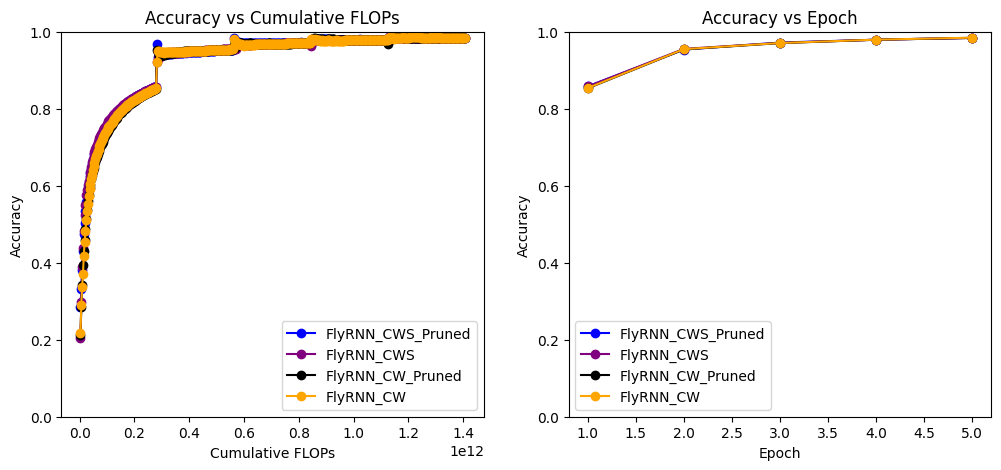

In [7]:
# 定义颜色（FruitFlyRNN: blue, Perceptron: green, Logistic Regression: red）
colors = {"FlyRNN_CWS_Pruned": "blue","FlyRNN_CWS": "purple", 
          "FlyRNN_CW_Pruned": "black","FlyRNN_CW": "orange", 
          "Perceptron": "green", "LogisticRegression": "red"}

# 第一张图：横轴均为累计 FLOPs，左侧面板为 Accuracy，右侧面板为 Loss（标准化后）
plt.figure(figsize=(12,5))

# 面板1：Accuracy vs Cumulative FLOPs (x轴：loaded_results[model]["flops"])
plt.subplot(1,2,1)
for model_name, data in loaded_results.items():
    plt.plot(data["flops"], data["acc"], marker='o', color=colors[model_name], label=model_name)
plt.title("Accuracy vs Cumulative FLOPs")
plt.xlabel("Cumulative FLOPs")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()

# 面板2：Accuracy vs Epoch
plt.subplot(1,2,2)
for model_name, data in loaded_results.items():
    epochs = range(1, len(data["epoch_acc"]) + 1)
    plt.plot(epochs, data["epoch_acc"], marker='o', color=colors[model_name], label=model_name)
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()



Using: cuda
[drosophila_pruning] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [01:06<00:00, 14.12batch/s, accuracy=0.722, loss=0.832]  


drosophila_pruning Epoch 1/5: Loss = 74301.0356, Accuracy = 72.25%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [00:55<00:00, 16.99batch/s, accuracy=0.793, loss=0.372] 


drosophila_pruning Epoch 2/5: Loss = 1.3005, Accuracy = 79.32%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [01:00<00:00, 15.42batch/s, accuracy=0.824, loss=0.662]


drosophila_pruning Epoch 3/5: Loss = 0.6777, Accuracy = 82.39%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [01:13<00:00, 12.68batch/s, accuracy=0.83, loss=0.293]  


drosophila_pruning Epoch 4/5: Loss = 1.0378, Accuracy = 83.03%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [01:20<00:00, 11.71batch/s, accuracy=0.832, loss=0.0714]


drosophila_pruning Epoch 5/5: Loss = 0.8834, Accuracy = 83.16%
[drosophila_pruning] FLOPs per sample: 4687776.0


Training [drosophila_pruning] Epoch 1/5: 100%|██████████| 938/938 [01:21<00:00, 11.47batch/s, accuracy=0.84, loss=0.419]  


drosophila_pruning Epoch 1/5: Loss = 0.5725, Accuracy = 83.97%


Training [drosophila_pruning] Epoch 2/5: 100%|██████████| 938/938 [01:20<00:00, 11.62batch/s, accuracy=0.846, loss=0.3]  


drosophila_pruning Epoch 2/5: Loss = 0.5792, Accuracy = 84.59%


Training [drosophila_pruning] Epoch 3/5: 100%|██████████| 938/938 [01:25<00:00, 10.97batch/s, accuracy=0.837, loss=0.45]  


drosophila_pruning Epoch 3/5: Loss = 0.8541, Accuracy = 83.74%


Training [drosophila_pruning] Epoch 4/5: 100%|██████████| 938/938 [01:21<00:00, 11.51batch/s, accuracy=0.844, loss=0.524]


drosophila_pruning Epoch 4/5: Loss = 1.6709, Accuracy = 84.45%


Training [drosophila_pruning] Epoch 5/5: 100%|██████████| 938/938 [01:21<00:00, 11.51batch/s, accuracy=0.848, loss=0.369]  


drosophila_pruning Epoch 5/5: Loss = 24.7783, Accuracy = 84.78%


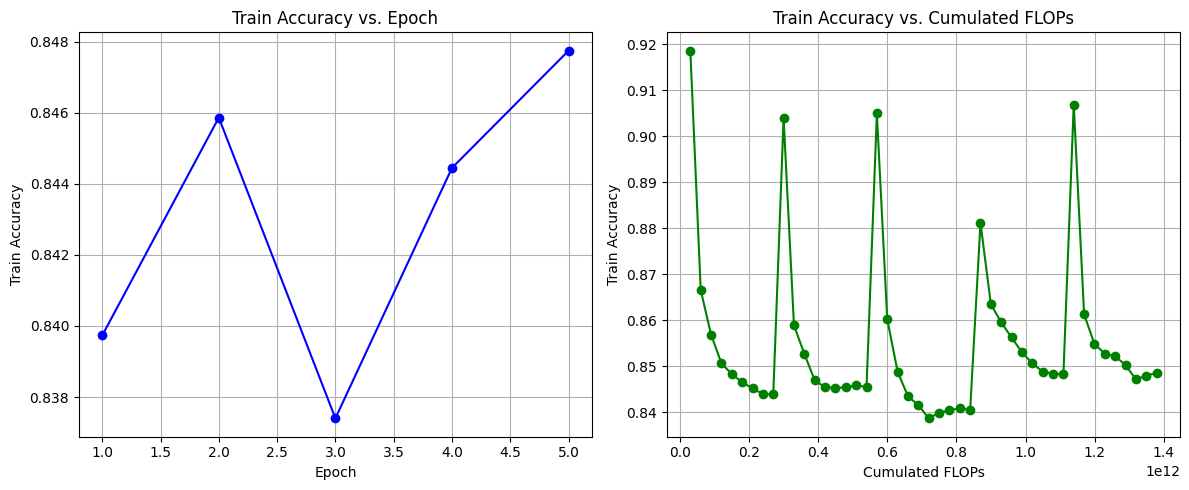

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from thop import profile
from scipy.optimize import linear_sum_assignment

############################
# 1. 读取并处理果蝇连接矩阵
############################
csv_path = './data/ad_connectivity_matrix.csv'
W_df = pd.read_csv(csv_path, index_col=0, header=0)
W = W_df.values.astype(np.float32)
W_min = W.min()
W_max = W.max()
W = (W - W_min) / (W_max - W_min + 1e-8)  # Normalize [0,1]

############################
# 2. 定义模型
############################
class DrosophilaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DrosophilaRNN, self).__init__()
        # 线性层：input -> hidden
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=True)
        # 线性层：hidden -> output
        self.hidden_to_output = nn.Linear(hidden_size, output_size, bias=True)
        
        # 随机初始化 W_matrix (可学习参数), 示例使用He初始化的简化形式
        # 如果你要特别小的初始化可以乘一个系数，例如 0.0001，但注意需要归一化后再算相似度。
        self.W_matrix = nn.Parameter(
            torch.randn(hidden_size, hidden_size) * 0.01
        )
        
        self.hidden_size = hidden_size

    def forward(self, x):
        """
        x 的形状: (batch_size, time_steps, input_size)
        例如 MNIST 情况下 x: (batch_size, 28, 28)
        """
        batch_size, time_steps, _ = x.shape
        # r(0) = 0
        r_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(time_steps):
            E_t = x[:, t, :]                   # (batch_size, input_size)
            E_t_hidden = self.input_to_hidden(E_t)
            r_prev = r_t                       # for residual

            # RNN隐藏状态更新
            r_t = r_t @ self.W_matrix          
            r_t = r_t + E_t_hidden + r_prev    # residual/skip
            r_t = torch.relu(r_t)

        out = self.hidden_to_output(r_t)       # (batch_size, output_size)
        return out

    def prune_weights(self, cost_matrix, target_nonzero_count):
        """
        使用匈牙利算法进行剪枝。保留与果蝇神经元连接最相似的那些权重。
        cost_matrix: (hidden_size, hidden_size) 的余弦相似度矩阵
        """
        # cost_matrix 形状: (hidden_size, hidden_size)
        # 将其拉平成一维
        cost_matrix_cpu = cost_matrix.cpu().numpy()  # 将 Tensor 转换为 NumPy 进行匈牙利算法处理

        # 使用匈牙利算法得到最优匹配
        row_ind, col_ind = linear_sum_assignment(cost_matrix_cpu, maximize=True)  # maximize=True 保留最大相似度

        # 构造掩码
        mask = torch.zeros_like(self.W_matrix)
        for i, j in zip(row_ind, col_ind):
            mask[i, j] = 1  # 保留相似度最高的连接

        # 应用掩码
        self.W_matrix.data *= mask

############################
# 3. 相似度计算函数
############################
def compute_similarity(W_rnn, W_droso):
    """
    基于余弦相似度的矩阵计算。
    假设:
    W_rnn: [hidden_size, hidden_size]
    W_droso: [hidden_size, hidden_size] (已在GPU上的tensor)
    """
    # 先对行做归一化 (dim=1)
    W_rnn_norm = nn.functional.normalize(W_rnn, p=2, dim=1)
    W_droso_norm = nn.functional.normalize(W_droso, p=2, dim=1)
    # 矩阵乘法 -> (hidden_size, hidden_size)
    similarity_matrix = torch.matmul(W_rnn_norm, W_droso_norm.T)
    return similarity_matrix

############################
# 4. 训练函数
############################
def train_model(model, optimizer, num_epochs, record_interval, device, train_loader, 
                dummy_input_shape, target_nonzero_count, W_droso_tensor, tag="drosophila"):
    
    criterion = nn.CrossEntropyLoss()
    epoch_loss_list = []
    epoch_acc_list = []

    # FLOPs 记录
    flops_list = []
    loss_list = []
    acc_list = []

    cumulative_flops = 0
    batch_counter = 0

    # 计算一次理论FLOPs
    dummy_input = torch.randn(dummy_input_shape).to(device)
    macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
    flops_per_sample = macs * 2  # MACs x 2 ~ FLOPs
    print(f"[{tag}] FLOPs per sample: {flops_per_sample}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        with tqdm(train_loader, unit="batch", desc=f"Training [{tag}] Epoch {epoch+1}/{num_epochs}") as tepoch:
            for images, labels in tepoch:
                # 维度: (batch_size, 1, 28, 28)
                # 转成 (batch_size, 28, 28)
                inputs = images.squeeze(1).to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # 防止梯度爆炸
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                batch_size_curr = inputs.size(0)
                running_loss += loss.item() * batch_size_curr
                _, predicted = torch.max(outputs, dim=1)
                running_correct += (predicted == labels).sum().item()
                running_total += batch_size_curr

                # 累积FLOPs
                cumulative_flops += flops_per_sample * batch_size_curr
                batch_counter += 1

                # 每隔 record_interval 记录一次指标
                if batch_counter % record_interval == 0:
                    current_loss = running_loss / running_total
                    current_acc = running_correct / running_total
                    flops_list.append(cumulative_flops)
                    loss_list.append(current_loss)
                    acc_list.append(current_acc)

                # 每100个batch进行一次剪枝
                if batch_counter % 100 == 0:
                    # 计算相似度
                    cost_matrix = compute_similarity(model.W_matrix.data, W_droso_tensor)
                    # 剪枝
                    model.prune_weights(cost_matrix, target_nonzero_count)

                tepoch.set_postfix(loss=loss.item(), accuracy=running_correct / running_total)

        # epoch 结束后
        epoch_loss = running_loss / running_total
        epoch_acc = running_correct / running_total
        epoch_loss_list.append(epoch_loss)
        epoch_acc_list.append(epoch_acc)

        print(f"{tag} Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")

    return epoch_loss_list, epoch_acc_list, flops_list, loss_list, acc_list


############################
# 5. 准备数据和超参数，开始训练
############################
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using:", device)
    tag = 'drosophila_pruning'

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST 常用归一化
    ])

    # MNIST 训练集
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    batch_size = 64
    nepochs = 5
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 果蝇连接矩阵维度
    hidden_size = W.shape[0]  # 假设 W.shape = (2953, 2953) 等
    # 将 W 转成 Tensor 并放到 GPU
    W_droso_tensor = torch.tensor(W, dtype=torch.float32, device=device)

    # 目标非零连接数量，根据果蝇连接矩阵中非零元素来定
    target_nonzero_count = torch.sum(torch.tensor(W != 0)).to(device)

    # 初始化 RNN 模型
    model = DrosophilaRNN(input_size=28, hidden_size=hidden_size, output_size=10)
    model.to(device)

    # 优化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 开始训练
    train_model(
        model, optimizer,
        num_epochs=nepochs,
        record_interval=100,
        device=device,
        train_loader=train_loader,
        dummy_input_shape=(1, 28, 28),
        target_nonzero_count=target_nonzero_count,
        W_droso_tensor=W_droso_tensor,
        tag=tag
    )
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(epoch_acc_list, flops_list, acc_list):
    """
    绘制训练过程中两个图表：
    1. train_accuracy vs. epoch
    2. train_accuracy vs. cummulated FLOPs

    参数:
        epoch_acc_list: 每个 epoch 结束时记录的训练准确率列表
        flops_list: 在记录间隔处累计的 FLOPs 列表
        acc_list: 在记录间隔处对应的训练准确率列表
    """
    # 绘制 train_accuracy vs. epoch
    epochs = np.arange(1, len(epoch_acc_list) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_acc_list, marker='o', linestyle='-', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Train Accuracy")
    plt.title("Train Accuracy vs. Epoch")
    plt.grid(True)
    
    # 绘制 train_accuracy vs. cummulated FLOPs
    plt.subplot(1, 2, 2)
    plt.plot(flops_list, acc_list, marker='o', linestyle='-', color='green')
    plt.xlabel("Cumulated FLOPs")
    plt.ylabel("Train Accuracy")
    plt.title("Train Accuracy vs. Cumulated FLOPs")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
# 训练结束后获取返回指标
epoch_loss_list, epoch_acc_list, flops_list, loss_list, acc_list = train_model(
    model, optimizer,
    num_epochs=nepochs,
    record_interval=100,
    device=device,
    train_loader=train_loader,
    dummy_input_shape=(1, 28, 28),
    target_nonzero_count=target_nonzero_count,
    W_droso_tensor=W_droso_tensor,
    tag=tag
)

# 绘图
plot_training_metrics(epoch_acc_list, flops_list, acc_list)


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from thop import profile
from scipy.optimize import linear_sum_assignment
import pickle

# 1. 读取并处理果蝇连接矩阵
csv_path = './data/ad_connectivity_matrix.csv'
W_df = pd.read_csv(csv_path, index_col=0, header=0)
W = W_df.values.astype(np.float32)
W_min = W.min()
W_max = W.max()
W = (W - W_min) / (W_max - W_min + 1e-8)  # Normalize [0,1]

# 2. 定义模型
class DrosophilaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, W_droso_tensor):
        super(DrosophilaRNN, self).__init__()
        self.input_to_hidden = nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_to_output = nn.Linear(hidden_size, output_size, bias=True)
        
        # 初始化 W_matrix (可学习和不可学习部分)
        self.W_matrix = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.001)
        self.register_buffer('W_droso', W_droso_tensor)  # 将果蝇连接矩阵作为buffer保存

        self.hidden_size = hidden_size
        self.lambda_l1 = 1e-5  # L1正则化的系数

    def forward(self, x):
        batch_size, time_steps, _ = x.shape
        r_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(time_steps):
            E_t = x[:, t, :]
            E_t_hidden = self.input_to_hidden(E_t)
            r_prev = r_t

            r_t = r_t @ self.W_matrix          
            r_t = r_t + E_t_hidden + r_prev    
            r_t = torch.relu(r_t)

        out = self.hidden_to_output(r_t)  
        return out

    def l1_regularization(self):
        return torch.sum(torch.abs(self.W_matrix))  # L1 正则化项

# FISTA优化算法实现
class FISTAOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, lambda_l1=1e-5):
        defaults = dict(lr=lr, lambda_l1=lambda_l1)
        super(FISTAOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                lr = group['lr']
                lambda_l1 = group['lambda_l1']

                # FISTA的加速步
                p.data = p.data - lr * d_p

                # L1正则化：软阈值处理
                p.data = torch.sign(p.data) * torch.maximum(torch.abs(p.data) - lr * lambda_l1, torch.zeros_like(p.data))
        return loss

# 3. 相似度计算函数
def compute_similarity(W_rnn, W_droso):
    W_rnn_norm = nn.functional.normalize(W_rnn, p=2, dim=1)
    W_droso_norm = nn.functional.normalize(W_droso, p=2, dim=1)
    similarity_matrix = torch.matmul(W_rnn_norm, W_droso_norm.T)
    return similarity_matrix

# 4. 训练函数
def train_model(model, optimizer, num_epochs, record_interval, device, train_loader, 
                dummy_input_shape, target_nonzero_count, W_droso_tensor, tag="drosophila"):
    
    criterion = nn.CrossEntropyLoss()
    epoch_loss_list = []
    epoch_acc_list = []

    # FLOPs 记录
    flops_list = []
    loss_list = []
    acc_list = []

    cumulative_flops = 0
    batch_counter = 0

    # 计算一次理论FLOPs
    dummy_input = torch.randn(dummy_input_shape).to(device)
    macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
    flops_per_sample = macs * 2  # MACs x 2 ~ FLOPs
    print(f"[{tag}] FLOPs per sample: {flops_per_sample}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        with tqdm(train_loader, unit="batch", desc=f"Training [{tag}] Epoch {epoch+1}/{num_epochs}") as tepoch:
            for images, labels in tepoch:
                inputs = images.squeeze(1).to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels) + model.l1_regularization()
                loss.backward()
                
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()

                batch_size_curr = inputs.size(0)
                running_loss += loss.item() * batch_size_curr
                _, predicted = torch.max(outputs, dim=1)
                running_correct += (predicted == labels).sum().item()
                running_total += batch_size_curr

                # 累积FLOPs
                cumulative_flops += flops_per_sample * batch_size_curr
                batch_counter += 1

                if batch_counter % record_interval == 0:
                    current_loss = running_loss / running_total
                    current_acc = running_correct / running_total
                    flops_list.append(cumulative_flops)
                    loss_list.append(current_loss)
                    acc_list.append(current_acc)

                tepoch.set_postfix(loss=loss.item(), accuracy=running_correct / running_total)

        epoch_loss = running_loss / running_total
        epoch_acc = running_correct / running_total
        epoch_loss_list.append(epoch_loss)
        epoch_acc_list.append(epoch_acc)

        print(f"{tag} Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc*100:.2f}%")

    return epoch_loss_list, epoch_acc_list, flops_list, loss_list, acc_list

# 5. 准备数据和超参数，开始训练
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tag = 'drosophila_fista'

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    batch_size = 64
    nepochs = 5
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    hidden_size = W.shape[0]
    W_droso_tensor = torch.tensor(W, dtype=torch.float32, device=device)

    target_nonzero_count = torch.sum(torch.tensor(W != 0)).to(device)

    model = DrosophilaRNN(input_size=28, hidden_size=hidden_size, output_size=10, W_droso_tensor=W_droso_tensor)
    model.to(device)

    optimizer = FISTAOptimizer(model.parameters(), lr=0.001, lambda_l1=1e-5)

    epoch_loss_list, epoch_acc_list, flops_list, loss_list, acc_list = train_model(
        model, optimizer,
        num_epochs=nepochs,
        record_interval=100,
        device=device,
        train_loader=train_loader,
        dummy_input_shape=(1, 28, 28),
        target_nonzero_count=target_nonzero_count,
        W_droso_tensor=W_droso_tensor,
        tag=tag
    )

    # 保存训练结果
    results = {
        'epoch_loss_list': epoch_loss_list,
        'epoch_acc_list': epoch_acc_list,
        'flops_list': flops_list,
        'loss_list': loss_list,
        'acc_list': acc_list
    }

    with open(f'{tag}_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print(f"Results saved to {tag}_results.pkl")


[drosophila_fista] FLOPs per sample: 4687776.0


Training [drosophila_fista] Epoch 1/5: 100%|██████████| 938/938 [00:37<00:00, 25.13batch/s, accuracy=0.301, loss=5.58e+3] 


drosophila_fista Epoch 1/5: Loss = 6257.7469, Accuracy = 30.14%


Training [drosophila_fista] Epoch 2/5: 100%|██████████| 938/938 [00:37<00:00, 25.03batch/s, accuracy=0.461, loss=4.38e+3]


drosophila_fista Epoch 2/5: Loss = 4966.6741, Accuracy = 46.14%


Training [drosophila_fista] Epoch 3/5: 100%|██████████| 938/938 [00:37<00:00, 25.09batch/s, accuracy=0.506, loss=3.35e+3]


drosophila_fista Epoch 3/5: Loss = 3847.8104, Accuracy = 50.55%


Training [drosophila_fista] Epoch 4/5: 100%|██████████| 938/938 [00:37<00:00, 25.07batch/s, accuracy=0.517, loss=2.49e+3]


drosophila_fista Epoch 4/5: Loss = 2902.5910, Accuracy = 51.73%


Training [drosophila_fista] Epoch 5/5: 100%|██████████| 938/938 [00:37<00:00, 25.01batch/s, accuracy=0.51, loss=1.8e+3]  

drosophila_fista Epoch 5/5: Loss = 2127.4043, Accuracy = 51.05%
Results saved to drosophila_fista_results.pkl
